In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/functions/')
from utils import detrend_members

In [2]:
# get nino3.4 data (not detrended):
path = '/glade/campaign/cgd/amp/jcaron/ongoing_projects/cvdp-le/output/final_cesm_e3sm_future_nonprime/1920-2100/'
ens = ['0101','0111','0121','0131','0141','0151','0161','0171','0181','0191',
       '0201','0211','0221','0231','0241','0251','0261','0271','0281','0291',
       '0301']

for e in range(len(ens)):
    finame = 'E3SM2_'+ens[e]+'.cvdp_data.1920-2100.nc'
    if e == 0:
        nino34 = xr.open_dataset(path+finame,decode_times=False)['nino34']
    elif e > 0:
        temp_nino34 = xr.open_dataset(path+finame,decode_times=False)['nino34']
        nino34 = xr.concat([nino34,temp_nino34],dim='ens')

newtime = pd.date_range("1920-01-01", freq="MS", periods=len(nino34.time))
nino34['time'] = newtime                           
nino34 = nino34.where((nino34.time.dt.year >= 1950) & (nino34.time.dt.year <= 2015), drop = True)

# nino34[0].plot()

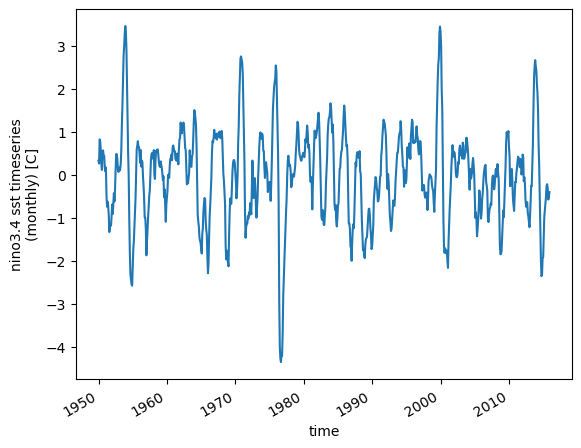

In [3]:
nino34[0].plot()

## Detrend & Remove Seasonal Cycle:

In [4]:
nino34_ensmean = nino34.mean('ens')

In [5]:
nino34_detrended = detrend_members(data = nino34, 
                                   ensmean_data = nino34_ensmean, 
                                   npoly=3)

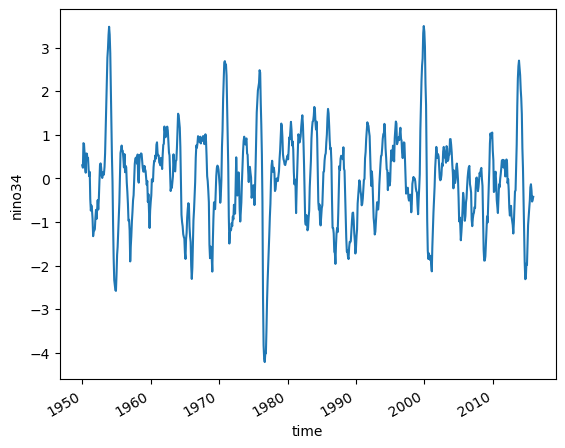

In [6]:
nino34_detrended[0].plot()

## Upsample monthly data to daily

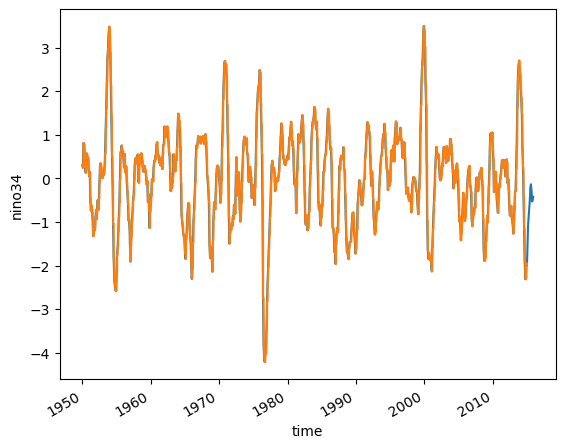

In [7]:
nino34_detrended_upsample = nino34_detrended.resample(time='1D').asfreq()
nino34_detrended_upsample = nino34_detrended_upsample.where(~((nino34_detrended_upsample.time.dt.month == 2) & (nino34_detrended_upsample.time.dt.day == 29)),drop=True)
nino34_detrended_upsample = nino34_detrended_upsample.ffill(dim='time')
nino34_detrended_upsample = nino34_detrended_upsample[:,6:-335] # 6: account for days 1-6 missing in X because of rolling mean; 
                                                                #-355: had to go through 2015 (not 2014) to get all days in Dec 2014 (not just 12-01-2014)
nino34_detrended[0].plot()
nino34_detrended_upsample[0].plot()

In [10]:
# ------ LOAD & Add State-Dependent SHIFT --------
ppath = '/glade/derecho/scratch/kjmayer/DATA/E3SMv2/PRECT/'
lead = 14
shift = 60

inino = 0
inina = 0
for m in range(len(ens)):
    print(m)
    pfiname = 'PRECT_mem'+ens[m]+'_7daymean_1950-2014_20S-20N_regrid2.5x2.5_polydetrend_allmems.nc'
    X = xr.open_dataarray(ppath+pfiname)
    
    for i in range(len(X)):
        if nino34_detrended_upsample[m,i] > 1:
            inino+=1
            # plt.imshow(X[i], origin = 'lower',vmin=-20, vmax=20, cmap='RdBu_r')
            # plt.show()
            X[i] = X[i].assign_coords(lon=np.append(np.arange(shift+2.5,360,2.5), np.arange(0,shift+2.5,2.5))).sortby('lon')# np.arange(182.5,360,2.5), np.arange(0,182.5,2.5))).sortby('lon')
            # plt.imshow(X[i], origin = 'lower',vmin=-20, vmax=20, cmap='RdBu_r')
            # plt.show()
        if nino34_detrended_upsample[m,i] < -1:
            inina+=1
            # plt.imshow(X[i], origin = 'lower',vmin=-20, vmax=20, cmap='RdBu_r')
            # plt.show()
            X[i] = X[i].assign_coords(lon=np.append(np.arange(shift+2.5,360,2.5), np.arange(0,shift+2.5,2.5))).sortby('lon')
            # plt.imshow(X[i], origin = 'lower',vmin=-20, vmax=20, cmap='RdBu_r')
            # plt.show()
    
    X.to_netcdf(ppath+'PRECT'+str(shift)+'Eshift_mem'+ens[m]+'_7daymean_1950-2014_20S-20N_regrid2.5x2.5_polydetrend_allmems.nc')
# ---------------------------------------------------
print(inino)
print(inina)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
74434
78720
